# Etude de cohorte

Une ***cohort*** est un groupe de personnes partageant des caractéristiques communes au cours d’une période spécifique.


L’analyse de cohortes est une méthode qui permet d’analyser et d’anticiper le comportement de ses clients et ainsi de mieux les comprendre. On peut, par exemple, déterminer le revenu qu’ils génèrent actuellement, la date de leur prochaine commande, et donc le chiffre d’affaires potentiel qu’ils généreront dans les prochaines années. Une analyse de cohortes est essentielle pour déterminer la « fameuse » Life-Time Value de ses clients.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime
import numpy as np
pd.set_option('display.max_rows', 200)

In [2]:
df = pd.read_csv("KaDo_clean.csv", parse_dates=True)

In [71]:
df.head()

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID,MOIS_ACQUISITION,CohortIndex,INDEX_COHORTE
0,35592159,10,1.67,HYGIENE,DOUCHE,JARDIMONDE,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281,10,1,1
1,35592159,10,1.66,HYGIENE,DOUCHE,JARDIMONDE,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281,10,1,1
2,35592159,10,7.45,SOINS DU VISAGE,JEUNES,CREMES JOUR,CR JR PARF BIO.SPE AC.SENT.50ML,1490281,10,1,1
3,35592159,10,5.95,SOINS DU VISAGE,ANTI-AGE ANTI-RIDES,DEMAQUILLANTS,EAU MICELLAIRE 3 THES FL200ML,1490281,10,1,1
4,35592159,10,1.67,HYGIENE,DOUCHE,JARDIMONDE,GD JDM4 TIARE FL 200ML,1490281,10,1,1


In [4]:
#Transform MOIS_VENTE values en mois

df['MOIS_VENTE'] = df['MOIS_VENTE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').month)

In [5]:
grouping = df.groupby('CLI_ID')['MOIS_VENTE']

In [6]:
df['MOIS_ACQUISITION'] = grouping.transform('min')

In [7]:
# Extract Cohort Index si MOIS_VENTE en datetime

# invoice_month = pd.DatetimeIndex(df['MOIS_VENTE']).month
# cohort_month = pd.DatetimeIndex(df['MOIS_ACQUISITION']).month
# months_diff = invoice_month - cohort_month
# df['CohortIndex'] = months_diff + 1

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7245425 entries, 0 to 7245424
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   TICKET_ID         int64  
 1   MOIS_VENTE        int64  
 2   PRIX_NET          float64
 3   FAMILLE           object 
 4   UNIVERS           object 
 5   MAILLE            object 
 6   LIBELLE           object 
 7   CLI_ID            int64  
 8   MOIS_ACQUISITION  int64  
 9   CohortIndex       int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 552.8+ MB


In [9]:
#Extract Cohort Index
months_diff = df['MOIS_VENTE'] - df['MOIS_ACQUISITION']
df['INDEX_COHORTE'] = months_diff + 1

In [10]:
grouping = df.groupby(['MOIS_ACQUISITION', 'INDEX_COHORTE'])
cohort_data = grouping['CLI_ID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'MOIS_ACQUISITION',columns = 'INDEX_COHORTE', values = 'CLI_ID')

In [11]:
cohort_counts

INDEX_COHORTE,1,2,3,4,5,6,7,8,9,10,11,12
MOIS_ACQUISITION,,,,,,,,,,,,
1,211942.0,53282.0,61094.0,62906.0,64143.0,73151.0,73761.0,59780.0,67437.0,55633.0,60578.0,72386.0
2,94723.0,21125.0,23053.0,25102.0,28860.0,27957.0,23159.0,26132.0,20869.0,23182.0,28722.0,NaN
3,86924.0,15003.0,17659.0,21639.0,21412.0,16796.0,18895.0,15149.0,16995.0,21553.0,NaN,NaN
4,65766.0,11226.0,14484.0,15134.0,11733.0,12880.0,10382.0,11848.0,15456.0,NaN,NaN,NaN
5,61183.0,11008.0,11513.0,9004.0,10051.0,8218.0,9370.0,13068.0,NaN,NaN,NaN,NaN
6,64393.0,10848.0,8538.0,10074.0,7846.0,9076.0,12578.0,NaN,NaN,NaN,NaN,NaN
7,67457.0,7755.0,8067.0,7164.0,8213.0,11549.0,NaN,NaN,NaN,NaN,NaN,NaN
8,39677.0,5115.0,4401.0,4829.0,6827.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,40121.0,5357.0,5319.0,7433.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On considère la date d'acquisition d'un client à partir de sa facture la plus ancienne. Cela est surement faussé étant donné qu'il soit possible qu'un client ait fait un achat antérieurement à Janvier 2020.


In [12]:
# Taux de rétention des cohortes

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.round(3) * 100

INDEX_COHORTE,1,2,3,4,5,6,7,8,9,10,11,12
MOIS_ACQUISITION,,,,,,,,,,,,
1,100.0,25.1,28.8,29.7,30.3,34.5,34.8,28.2,31.8,26.2,28.6,34.2
2,100.0,22.3,24.3,26.5,30.5,29.5,24.4,27.6,22.0,24.5,30.3,NaN
3,100.0,17.3,20.3,24.9,24.6,19.3,21.7,17.4,19.6,24.8,NaN,NaN
4,100.0,17.1,22.0,23.0,17.8,19.6,15.8,18.0,23.5,NaN,NaN,NaN
5,100.0,18.0,18.8,14.7,16.4,13.4,15.3,21.4,NaN,NaN,NaN,NaN
6,100.0,16.8,13.3,15.6,12.2,14.1,19.5,NaN,NaN,NaN,NaN,NaN
7,100.0,11.5,12.0,10.6,12.2,17.1,NaN,NaN,NaN,NaN,NaN,NaN
8,100.0,12.9,11.1,12.2,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100.0,13.4,13.3,18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Moyenne prix d'un article par cohorte

grouping = df.groupby(['MOIS_ACQUISITION', 'INDEX_COHORTE'])
cohort_data = grouping['PRIX_NET'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='MOIS_ACQUISITION', columns='INDEX_COHORTE', values='PRIX_NET')
average_quantity.round(1)

INDEX_COHORTE,1,2,3,4,5,6,7,8,9,10,11,12
MOIS_ACQUISITION,,,,,,,,,,,,
1,5.5,6.7,6.4,6.3,7.2,5.8,5.7,5.4,6.1,6.4,6.4,5.4
2,6.9,6.4,6.3,7.4,5.9,5.8,5.4,6.1,6.4,6.6,5.5,NaN
3,6.4,6.2,7.1,5.8,5.7,5.4,6.1,6.3,6.5,5.4,NaN,NaN
4,6.4,6.7,5.7,5.7,5.4,6.0,6.2,6.4,5.3,NaN,NaN,NaN
5,6.9,5.7,5.6,5.3,5.8,6.1,6.3,5.4,NaN,NaN,NaN,NaN
6,5.8,5.5,5.2,5.7,5.8,6.3,5.2,NaN,NaN,NaN,NaN,NaN
7,5.7,5.1,5.7,5.9,6.4,5.3,NaN,NaN,NaN,NaN,NaN,NaN
8,5.5,5.5,5.7,6.2,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6.1,5.5,6.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


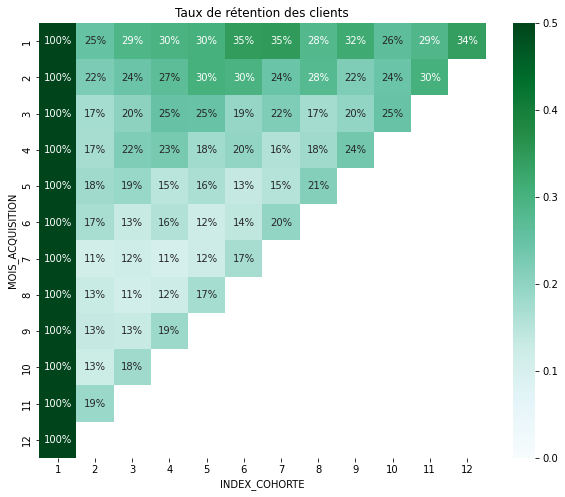

In [14]:
plt.figure(figsize=(10,8))
plt.title('Taux de rétention des clients')
sns.heatmap(data=retention, annot=True, fmt='.0%',vmin=0.0,vmax=0.5,cmap='BuGn')
plt.show()

# Segmentation RFM (Récence, Fréquence, Montant)

La méthode de segmentation RFM permet un classement des clients en fonction de leurs habitudes d'achat. On peut ainsi optimiser une stratégie marketing en fonction de nos clients.

Le classement RFM se fait en fonction de 3 critères :

- Récence : date du dernier achat ou dernier contact client
- Fréquence : fréquence des achats sur une période de référence donnée
- Montant : somme des achats cumulés sur cette période

## Montant

Nous allons classé les clients en fonction du montant total de leur dépense sur notre site. Chaque quartile représente un groupe de 25% de nos clients. Ainsi le quartile 1 représente les 25% de clients qui dépensent le moins et le quartile 4 représente les 25% de clients qui dépensent le plus.

In [15]:
cli_total_spent = df.groupby('CLI_ID').agg(sum)['PRIX_NET']

In [16]:
total_spent_quartile = pd.qcut(cli_total_spent, q=4, labels=range(1,5))
total_spent_quartile

CLI_ID
1490281      2
13290776     3
20163348     1
20200041     1
20561854     1
            ..
997048745    2
997048751    2
997048769    4
997048777    4
997385337    4
Name: PRIX_NET, Length: 853511, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

## Récence

Nous allons classés les clients en fonction du temps depuis leur dernier achat.


In [17]:
cli_last_purchase = df[['CLI_ID', 'MOIS_VENTE']].groupby('CLI_ID').agg('max')

In [18]:
cli_recency = 13 - cli_last_purchase

In [19]:
recency_quartile = pd.qcut(cli_recency['MOIS_VENTE'], q=3, labels=['ACTIVE','OCCASIONNEL','INACTIVE'])

In [20]:
recency_quartile

CLI_ID
1490281      OCCASIONNEL
13290776          ACTIVE
20163348        INACTIVE
20200041        INACTIVE
20561854        INACTIVE
                ...     
997048745    OCCASIONNEL
997048751    OCCASIONNEL
997048769         ACTIVE
997048777    OCCASIONNEL
997385337         ACTIVE
Name: MOIS_VENTE, Length: 853511, dtype: category
Categories (3, object): ['ACTIVE' < 'OCCASIONNEL' < 'INACTIVE']

## Fréquence

La fréquence représente le nombre de commande que le client a passé ces 12 derniers mois.

In [21]:
cli_frequency = df[['CLI_ID', 'TICKET_ID']].groupby('CLI_ID').agg(pd.Series.nunique)

In [22]:
cli_frequency

,TICKET_ID
CLI_ID,
1490281,1
13290776,2
20163348,1
20200041,1
20561854,1
...,...
997048745,1
997048751,2
997048769,3


In [23]:
frequency_quartile = pd.qcut(cli_frequency['TICKET_ID'], q=2, labels=['OCCASIONNEL','REGULIER'])

In [24]:
frequency_quartile

CLI_ID
1490281      OCCASIONNEL
13290776     OCCASIONNEL
20163348     OCCASIONNEL
20200041     OCCASIONNEL
20561854     OCCASIONNEL
                ...     
997048745    OCCASIONNEL
997048751    OCCASIONNEL
997048769       REGULIER
997048777       REGULIER
997385337       REGULIER
Name: TICKET_ID, Length: 853511, dtype: category
Categories (2, object): ['OCCASIONNEL' < 'REGULIER']

In [25]:
data = {'RECENCE': cli_recency['MOIS_VENTE'], 'FREQUENCE': cli_frequency['TICKET_ID'], 'MONTANT': cli_total_spent }
RFM_df = pd.DataFrame(data=data, index = cli_recency.index )

In [26]:
RFM_df.to_csv('RFM.csv', index=False)

In [27]:
RFM_df

,RECENCE,FREQUENCE,MONTANT
CLI_ID,,,
1490281,3,1,18.40
13290776,1,2,55.50
20163348,12,1,7.45
20200041,12,1,6.70
20561854,10,1,7.05
...,...,...,...
997048745,5,1,19.80
997048751,3,2,28.80
997048769,1,3,72.65


In [28]:
print(f"Le montant de dépense moyen par client sur l'année est de {np.mean(RFM_df['MONTANT']):.2f}€.")
print(f"En moyenne la date du dernier achat du client remonte à {np.mean(RFM_df['RECENCE']):.2f} mois.")
print(f"En moyenne un client commande {np.mean(RFM_df['FREQUENCE']):.2f} fois par an.")

Le montant de dépense moyen par client sur l'année est de 50.68€.
En moyenne la date du dernier achat du client remonte à 4.18 mois.
En moyenne un client commande 3.20 fois par an.


N'ayant pas beaucoup de mois ni de frequence d'achat on décide de segmenter ces deux variables Recence et Fréquence en 2 segments.
Le montant quant à lui est segmenté en 4 segments


In [29]:
r_quartiles = pd.qcut(RFM_df['RECENCE'], 2, range(2,0,-1))
f_quartiles = pd.qcut(RFM_df['FREQUENCE'], 2, range(1,3))
m_quartiles = pd.qcut(RFM_df['MONTANT'], 4, range(1,5))
RFM_df['R'] = r_quartiles
RFM_df['F'] = f_quartiles.values
RFM_df['M'] = m_quartiles.values

In [30]:
RFM_df.head()

,RECENCE,FREQUENCE,MONTANT,R,F,M
CLI_ID,,,,,,
1490281,3,1,18.40,2,1,2
13290776,1,2,55.50,2,1,3
20163348,12,1,7.45,1,1,1
20200041,12,1,6.70,1,1,1
20561854,10,1,7.05,1,1,1


In [31]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

In [32]:
RFM_df['RFM_SEGMENT'] = RFM_df.apply(join_rfm, axis=1)
RFM_df['RFM_SCORE'] = RFM_df[['R','F','M']].sum(axis=1)

In [33]:
RFM_df

,RECENCE,FREQUENCE,MONTANT,R,F,M,RFM_SEGMENT,RFM_SCORE
CLI_ID,,,,,,,,
1490281,3,1,18.40,2,1,2,212,5
13290776,1,2,55.50,2,1,3,213,6
20163348,12,1,7.45,1,1,1,111,3
20200041,12,1,6.70,1,1,1,111,3
20561854,10,1,7.05,1,1,1,111,3
...,...,...,...,...,...,...,...,...
997048745,5,1,19.80,1,1,2,112,4
997048751,3,2,28.80,2,1,2,212,5
997048769,1,3,72.65,2,2,4,224,8


In [34]:
RFM_df.to_csv('RFM_data.csv', index=False)

## Analyse des segments RFM

In [35]:
#Largest RFM segment
RFM_df.groupby('RFM_SEGMENT').size().sort_values(ascending=False)[:10]

RFM_SEGMENT
224    163833
111    144641
112    107132
223     85198
211     63130
212     62323
113     53275
213     38845
123     36140
124     31428
dtype: int64

On se rend compte que les segments les plus représentés sont les clients regulier, actif et avec un montant d'achat assez conséquent.

Le deuxieme segment le plus représenté est celui des clients occasionnels, inactifs et avec un montant d'achat annuel bas.

In [36]:
RFM_df.groupby('RFM_SCORE').agg({
    'RECENCE': 'mean',
    'FREQUENCE': 'mean',
    'MONTANT': ['mean', 'count']
}).round(1)

RECENCE FREQUENCE MONTANT        
             mean      mean    mean   count
RFM_SCORE                                  
3             7.7       1.1     7.4  144641
4             5.4       1.3    15.5  172533
5             4.4       1.8    28.6  135159
6             3.4       2.9    42.0  112392
7             2.5       4.4    64.7  124953
8             1.5       7.5   139.4  163833

Les clients ayant un score RFM de 3 n'ont plus acheté depuis en moyenne 6.7 mois, achète 1.1 fois par an pour un total de dépense de 7.4€.

Les clients ayant un score RFM de 8 ont commandé en moyenne les 15 derniers jours, ont une fréquence d'achat de 7.5 par an pour un montant de dépense annuel moyen de 139€

In [37]:
def segment_me(df):
    if df['RFM_SCORE'] >= 7:
        return '1. Gold'
    elif (df['RFM_SCORE'] >=5) and (df['RFM_SCORE'] <7):
        return '2. Silver'
    else:
        return '3. Bronze'

In [38]:
RFM_df['GENERAL_SEGMENT']= RFM_df.apply(segment_me, axis = 1)

In [39]:
RFM_df.groupby('GENERAL_SEGMENT').agg({
    'RECENCE': 'mean',
    'FREQUENCE': 'mean',
    'MONTANT': ['mean', 'count']
}).round(1)

RECENCE FREQUENCE MONTANT        
                   mean      mean    mean   count
GENERAL_SEGMENT                                  
1. Gold             1.9       6.2   107.1  288786
2. Silver           3.9       2.3    34.7  247551
3. Bronze           6.4       1.2    11.8  317174

## Preprocessing Data pour le Kmeans

Les données doivent être symetriques, avoir la même moyenne et la même variance afin d'être donné à l'algorithme du Kmeans. 
Afin d'avoir les bonnes données, on doit:

    - Mettre les données à l'échelle logarithmique afin d'avoir un maximum de symétrie
    - Centrer-réduire les données afin qu'elles aient une espérance nulle et une variance et écart-type égal à 1.

In [40]:
RFM_preprocessed = RFM_df.drop(columns=['GENERAL_SEGMENT','R','F','M','RFM_SEGMENT', 'RFM_SCORE'])

c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

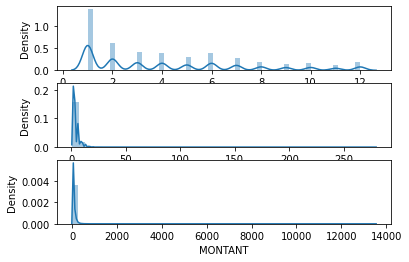

In [41]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(RFM_preprocessed['RECENCE'])

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(RFM_preprocessed['FREQUENCE'])

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(RFM_preprocessed['MONTANT'])

# Show the plot
plt.show()

In [82]:
RFM_preprocessed.head()

,RECENCE,FREQUENCE,MONTANT
CLI_ID,,,
1490281,3,1,18.40
13290776,1,2,55.50
20163348,12,1,7.45
20200041,12,1,6.70
20561854,10,1,7.05


In [43]:
RFM_preprocessed_log = np.log(RFM_preprocessed)

In [44]:
RFM_preprocessed_log.describe()

,RECENCE,FREQUENCE,MONTANT
count,853511.000000,853511.000000,853511.000000
mean,1.086181,0.826678,3.352522
std,0.862573,0.787418,1.110809
min,0.000000,0.000000,-0.693147
25%,0.000000,0.000000,2.595255
50%,1.098612,0.693147,3.392493
75%,1.791759,1.386294,4.147885
max,2.484907,5.631212,9.513178


In [45]:
scaler = StandardScaler()
scaler.fit(RFM_preprocessed_log)
RFM_normalized = scaler.transform(RFM_preprocessed_log)

In [46]:
RFM_data_normalized = pd.DataFrame(RFM_normalized, index=RFM_preprocessed.index, columns=RFM_preprocessed.columns)

c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\tom\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

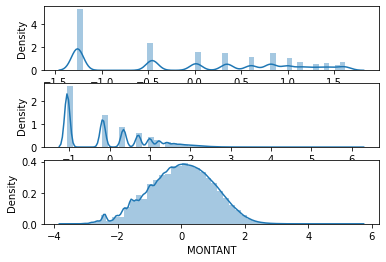

In [47]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(RFM_data_normalized['RECENCE'])

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(RFM_data_normalized['FREQUENCE'])

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(RFM_data_normalized['MONTANT'])

# Show the plot
plt.show()

### Choix du nombre de k

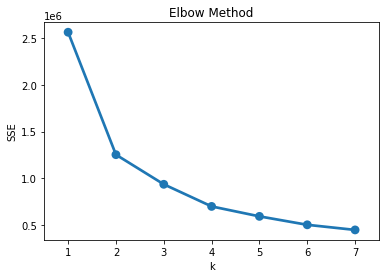

In [48]:
sse = {}
for k in range(1,8):
    kmeans=KMeans(n_clusters=k, random_state=1)
    kmeans.fit(RFM_data_normalized)
    sse[k] = kmeans.inertia_

plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
    

### Implémentation du KMeans avec 3 clusters

In [49]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(RFM_data_normalized)
cluster_labels = kmeans.labels_

In [50]:
RFM_df['Cluster'] = cluster_labels

In [51]:
RFM_df.head()

,RECENCE,FREQUENCE,MONTANT,R,F,M,RFM_SEGMENT,RFM_SCORE,GENERAL_SEGMENT,Cluster
CLI_ID,,,,,,,,,,
1490281,3,1,18.40,2,1,2,212,5,2. Silver,0
13290776,1,2,55.50,2,1,3,213,6,2. Silver,2
20163348,12,1,7.45,1,1,1,111,3,3. Bronze,0
20200041,12,1,6.70,1,1,1,111,3,3. Bronze,0
20561854,10,1,7.05,1,1,1,111,3,3. Bronze,0


In [66]:
RFM_data_normalized.head()

,RECENCE,FREQUENCE,MONTANT,R,F,M,RFM_SEGMENT,RFM_SCORE,GENERAL_SEGMENT,Cluster
CLI_ID,,,,,,,,,,
1490281,0.014412,-1.049860,-0.396262,NaN,NaN,NaN,NaN,NaN,NaN,0
13290776,-1.259234,-0.169581,0.597638,NaN,NaN,NaN,NaN,NaN,NaN,2
20163348,1.621575,-1.049860,-1.210207,NaN,NaN,NaN,NaN,NaN,NaN,0
20200041,1.621575,-1.049860,-1.305729,NaN,NaN,NaN,NaN,NaN,NaN,0
20561854,1.410206,-1.049860,-1.259888,NaN,NaN,NaN,NaN,NaN,NaN,0


In [53]:
RFM_df.groupby(['Cluster']).agg({
    'RECENCE': 'mean',
    'FREQUENCE': 'mean',
    'MONTANT': ['mean', 'count']
}).round(2)

RECENCE FREQUENCE MONTANT        
           mean      mean    mean   count
Cluster                                  
0          7.16      1.44   20.11  368618
1          2.14      6.22  104.70  299528
2          1.54      1.84   24.18  185365

Le Kmeans a crée 3 groupes de cluster:
- le cluster 0 regroupe les clients inactifs qui rapportent peu.
- le cluster 1 regroupe les clients actifs qui rapportent beaucoup.
- le cluster 2 regroupe les clients actifs qui rapportent peu.

Cette segmentation permettrai de cibler la campagne marketing selon les clusters.

Cluster 0, mettre en place une promotion assez conséquente pour déclencer un achat sur le site et espérer avoir une meilleur rétention par la suite.

Cluster 1, mettre une promotion à partir de X montant d'achat pour faire gonfler leur panier.

Cluster 2, faire des petites promotions régulièrement pour faire en sorte qu'ils continuent à faire leur achat sur notre plateforme.

## Snake plot

In [67]:
RFM_data_normalized.head()

,RECENCE,FREQUENCE,MONTANT,R,F,M,RFM_SEGMENT,RFM_SCORE,GENERAL_SEGMENT,Cluster
CLI_ID,,,,,,,,,,
1490281,0.014412,-1.049860,-0.396262,NaN,NaN,NaN,NaN,NaN,NaN,0
13290776,-1.259234,-0.169581,0.597638,NaN,NaN,NaN,NaN,NaN,NaN,2
20163348,1.621575,-1.049860,-1.210207,NaN,NaN,NaN,NaN,NaN,NaN,0
20200041,1.621575,-1.049860,-1.305729,NaN,NaN,NaN,NaN,NaN,NaN,0
20561854,1.410206,-1.049860,-1.259888,NaN,NaN,NaN,NaN,NaN,NaN,0


In [68]:
RFM_data_normalized = pd.DataFrame(RFM_data_normalized, index=RFM_df.index, columns=RFM_df.columns)
RFM_data_normalized['Cluster'] = cluster_labels

In [69]:
RFM_data_melt = pd.melt(RFM_data_normalized.reset_index(), id_vars=['CLI_ID', 'Cluster'], value_vars=['RECENCE','FREQUENCE', 'MONTANT'],var_name = 'Attribute', value_name='Value')

<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

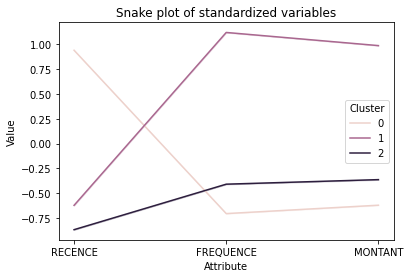

In [70]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=RFM_data_melt)

### Relative importance heatmap

In [65]:
RFM_data_normalized.head()

,RECENCE,FREQUENCE,MONTANT,R,F,M,RFM_SEGMENT,RFM_SCORE,GENERAL_SEGMENT,Cluster
CLI_ID,,,,,,,,,,
1490281,0.014412,-1.049860,-0.396262,NaN,NaN,NaN,NaN,NaN,NaN,0
13290776,-1.259234,-0.169581,0.597638,NaN,NaN,NaN,NaN,NaN,NaN,2
20163348,1.621575,-1.049860,-1.210207,NaN,NaN,NaN,NaN,NaN,NaN,0
20200041,1.621575,-1.049860,-1.305729,NaN,NaN,NaN,NaN,NaN,NaN,0
20561854,1.410206,-1.049860,-1.259888,NaN,NaN,NaN,NaN,NaN,NaN,0


In [59]:
RFM_preprocessed_k3 = RFM_preprocessed.copy()

In [60]:
RFM_preprocessed_k3['Cluster'] = cluster_labels

In [61]:
cluster_avg = RFM_preprocessed_k3.groupby(['Cluster']).mean()
population_avg = RFM_preprocessed.mean()

In [62]:
relative_imp = cluster_avg / population_avg - 1

In [63]:
relative_imp

,RECENCE,FREQUENCE,MONTANT
Cluster,,,
0,0.713489,-0.550348,-0.603207
1,-0.487880,0.941551,1.065968
2,-0.630492,-0.427010,-0.522936


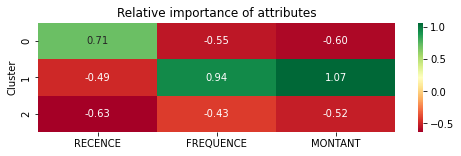

In [64]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Cette heatmap permet de voir l'importance des attributs selon chaque cluster.

Cluster 0, l'attribut récence est une critère important de ce cluster, en effet, ce clsuter contient les clients qui n'ont pas commandé depuis longtemps.

Cluster 1, la fréquence et le montant sont des attributs importants, on a pu constater que ce cluster regroupait tous les meilleurs clients

Cluster 2, regroupent les clients qui ne sont pas dans le cluster 0 ou 1. C'est à dire que le cluster 2 correspond aux clients neutre. C'est des clients plutot actifs mais qui ne sont pas forcément les meilleurs clients. 



### Exploration de la clusterisation en prenant en compte la saison préférée des acheteurs

In [72]:
df['MOIS_VENTE'] = df['MOIS_VENTE'].replace([1,2,3],4)
df['MOIS_VENTE'] = df['MOIS_VENTE'].replace([4,5,6],1)
df['MOIS_VENTE'] = df['MOIS_VENTE'].replace([7,8,9],2)
df['MOIS_VENTE'] = df['MOIS_VENTE'].replace([10,11,12],3)

In [74]:
grouping = df.groupby(['CLI_ID','MOIS_VENTE'])
prefered_month = grouping['TICKET_ID'].apply(pd.Series.nunique)

In [76]:
prefered_month = pd.DataFrame(data=prefered_month)

In [77]:
prefered_month

TICKET_ID
CLI_ID    MOIS_VENTE           
1490281   3                   1
13290776  2                   1
          3                   1
20163348  1                   1
20200041  1                   1
...                         ...
997048777 2                   3
          3                   1
997385337 1                   4
          2                   3
          3                   1

[1479997 rows x 1 columns]

In [78]:
prefered_month = prefered_month.reset_index(level=["MOIS_VENTE"])

In [79]:
prefered_month = prefered_month.groupby('CLI_ID')

In [80]:
max = prefered_month.max()

In [81]:
max

,MOIS_VENTE,TICKET_ID
CLI_ID,,
1490281,3,1
13290776,3,1
20163348,1,1
20200041,1,1
20561854,1,1
...,...,...
997048745,2,1
997048751,3,1
997048769,3,3


In [83]:
RFM_preprocessed

,RECENCE,FREQUENCE,MONTANT
CLI_ID,,,
1490281,3,1,18.40
13290776,1,2,55.50
20163348,12,1,7.45
20200041,12,1,6.70
20561854,10,1,7.05
...,...,...,...
997048745,5,1,19.80
997048751,3,2,28.80
997048769,1,3,72.65


In [85]:
RFM_preprocessed["PREFERED_SEASON"] = max['MOIS_VENTE']

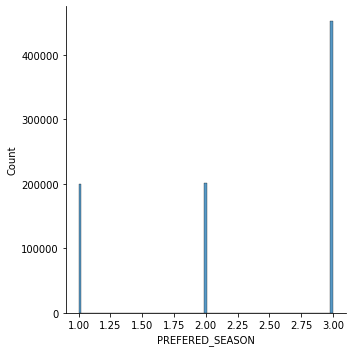

In [88]:
sns.displot(RFM_preprocessed['PREFERED_SEASON'])
plt.show()

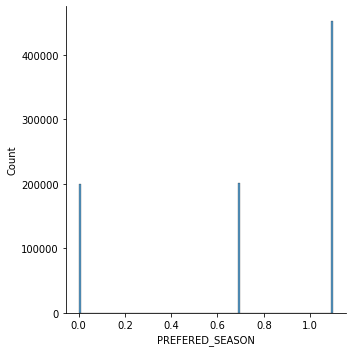

In [89]:
prefered_month_log = np.log(RFM_df["PREFERED_SEASON"])
sns.displot(prefered_month_log)
plt.show()

In [90]:
RFM_preprocessed_log = np.log(RFM_preprocessed)

In [91]:
RFM_preprocessed_log.describe()

,RECENCE,FREQUENCE,MONTANT,PREFERED_SEASON
count,853511.000000,853511.000000,853511.000000,853511.000000
mean,1.086181,0.826678,3.352522,0.745875
std,0.862573,0.787418,1.110809,0.443799
min,0.000000,0.000000,-0.693147,0.000000
25%,0.000000,0.000000,2.595255,0.693147
50%,1.098612,0.693147,3.392493,1.098612
75%,1.791759,1.386294,4.147885,1.098612
max,2.484907,5.631212,9.513178,1.098612


In [92]:
scaler = StandardScaler()
scaler.fit(RFM_preprocessed_log)
RFM_normalized = scaler.transform(RFM_preprocessed_log)

In [93]:
RFM_data_normalized_with_seasons = pd.DataFrame(RFM_normalized, index=RFM_preprocessed.index, columns=RFM_preprocessed.columns)

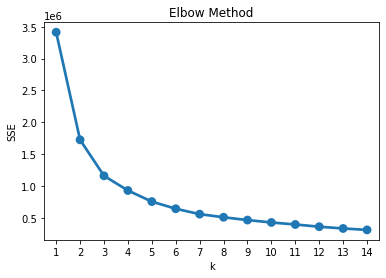

In [96]:
sse = {}
for k in range(1,15):
    kmeans=KMeans(n_clusters=k, random_state=1)
    kmeans.fit(RFM_data_normalized_with_seasons)
    sse[k] = kmeans.inertia_

plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [97]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(RFM_data_normalized_with_seasons)
cluster_labels = kmeans.labels_

In [98]:
df_rfm_k4 = RFM_preprocessed.assign(Cluster = cluster_labels) 
df_rfm_k4.groupby(['Cluster']).agg({ 
    'RECENCE': 'mean', 
    'FREQUENCE': 'mean', 
    'MONTANT': ['mean', 'count'],
    'PREFERED_SEASON': ['mean','count']
}).round(2)

RECENCE FREQUENCE MONTANT         PREFERED_SEASON        
           mean      mean    mean   count            mean   count
Cluster                                                          
0          9.20      1.43   22.62  199750            1.00  199750
1          1.78      6.43  107.95  275294            2.91  275294
2          1.73      1.72   22.28  202265            3.00  202265
3          5.06      1.87   25.62  176202            2.00  176202

In [101]:
RFM_data_normalized_with_seasons['Cluster'] = df_rfm_k4["Cluster"]
RFM_data_normalized_with_seasons

,RECENCE,FREQUENCE,MONTANT,PREFERED_SEASON,Cluster
CLI_ID,,,,,
1490281,0.014412,-1.049860,-0.396262,0.794813,2
13290776,-1.259234,-0.169581,0.597638,0.794813,2
20163348,1.621575,-1.049860,-1.210207,-1.680661,0
20200041,1.621575,-1.049860,-1.305729,-1.680661,0
20561854,1.410206,-1.049860,-1.259888,-1.680661,0
...,...,...,...,...,...
997048745,0.606624,-1.049860,-0.330246,-0.118811,3
997048751,0.014412,-0.169581,0.007070,0.794813,2
997048769,-1.259234,0.345350,0.840047,0.794813,1


In [102]:
df_melt = pd.melt(RFM_data_normalized_with_seasons.reset_index(),
                 id_vars=["CLI_ID","Cluster"],
                 value_vars=['RECENCE',"FREQUENCE","MONTANT","PREFERED_SEASON"],
                 var_name="Attribute",
                 value_name="Value")

<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

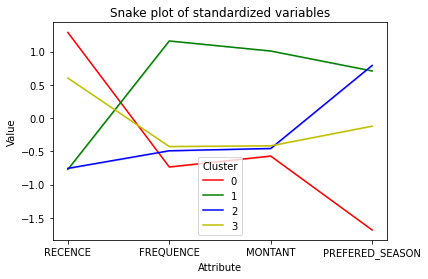

In [103]:
plt.title('Snake plot of standardized variables') 
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=df_melt, palette=['r', 'g','b', 'y'])

In [ ]:
cluster_avg = df_rfm_k4.groupby(['Cluster']).mean()
population_avg = RFM_df.mean()  
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2) 

In [ ]:
plt.figure(figsize=(8, 2)) 
plt.title('Relative importance of attributes') 
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn') 
plt.show()